In [32]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# libraries for partitioning and batching the data
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

# for dataset management
import pandas as pd
import time

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url,sep=';')
data.head(1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
### z-score all variables except for quality

# find the columns we want to normalize (all except quality)
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')

# z-score (written out for clarity)
for col in cols2zscore:
  meanval   = np.mean(data[col])
  stdev     = np.std(data[col],ddof=1)
  data[col] = (data[col]-meanval) / stdev

In [4]:
# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

C:\Users\pmiha\AppData\Local\Temp\ipykernel_15240\2413745517.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['boolQuality'][data['quality']>5] = 1
C:\Users\pmiha\AppData\Local\Temp\ipykernel_15240\2413745517.py:4: SettingWithCopyWar

In [5]:
data.drop('quality',axis=1,inplace=True)

In [6]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None]


In [15]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.2)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
batchsize    = 128
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)  
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [8]:
2**np.arange(3,10,2)

array([  8,  32, 128, 512])

In [9]:
dataT.shape

torch.Size([1599, 11])

In [27]:
# a class that creates the ANN model
def createANewModel():
  
  class ANNModel(nn.Module):
    def __init__(self):
      super().__init__()
      
      self.input = nn.Linear(11, 16)
      self.fc1 = nn.Linear(16, 32)
      self.fc2 = nn.Linear(32, 32)
      self.output = nn.Linear(32, 1)    
      
      self.relu = nn.ReLU()

    def forward(self, x):
      x = self.relu(self.input(x))
      x = self.relu(self.fc1(x))
      x = self.relu(self.fc2(x))
      return self.output(x)
    
  # instantiate the model
  ANNwine = ANNModel()

  # loss function
  lossfun = nn.BCEWithLogitsLoss()
  
  # optimizer
  optimizer = torch.optim.SGD(ANNwine.parameters(), lr=.01)

  return ANNwine, lossfun, optimizer    
    

In [28]:
# train the model

# global parameter
numepochs = 1000

def trainTheModel(winenet):

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # activate training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
      batchLoss.append( loss.item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)


    ### test accuracy

    # extract X,y from test dataloader
    X,y = next(iter(test_loader))

    # activate testing mode
    winenet.eval()
    with torch.no_grad():
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses


In [29]:
ANNwine,lossfun,optimizer  = createANewModel()
trainAcc,testAcc,losses = trainTheModel(ANNwine)

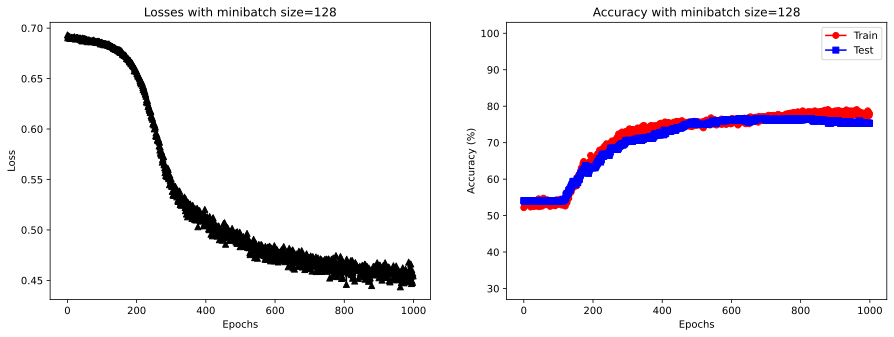

In [30]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with minibatch size=' + str(batchsize))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with minibatch size=' + str(batchsize))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])
ax[1].set_ylim([27,103])

plt.show()

In [34]:
# range of batch sizes
batchsizes = 2**np.arange(3,10,2)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs,len(batchsizes)))
accuracyResultsTest  = np.zeros((numepochs,len(batchsizes)))
comptime             = np.zeros(len(batchsizes))

test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

for batch in range(len(batchsizes)):
    
    starttime= time.process_time()
    
    train_loader = DataLoader(train_data,batch_size=int(batchsizes[batch]),shuffle=True,drop_last=True)
    
    ANNwine,lossfun,optimizer  = createANewModel()
    trainAcc,testAcc,losses = trainTheModel(ANNwine)
    
    accuracyResultsTrain[:,batch] = trainAcc
    accuracyResultsTest[:,batch]  = testAcc
    comptime[batch] = time.process_time() - starttime
    
    

In [35]:
comptime

array([646.96875, 214.71875,  87.9375 ,  58.90625])

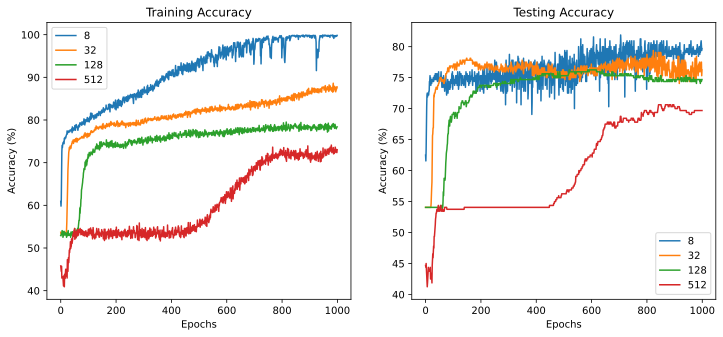

In [41]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Training Accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Testing Accuracy')

for i in range(2):
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].legend(batchsizes)

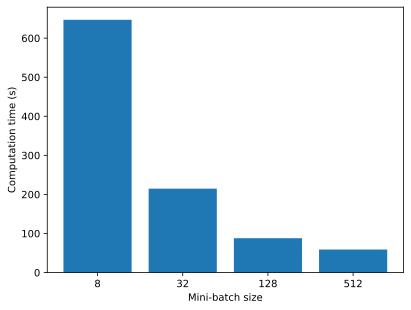

In [42]:
# bar plot of computation time
plt.bar(range(len(comptime)),comptime,tick_label=batchsizes)
plt.xlabel('Mini-batch size')
plt.ylabel('Computation time (s)')
plt.show()